<a href="https://colab.research.google.com/github/lana-chloe/score-based-model/blob/main/score_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import torch.nn as nn


class SDE:

    def __init__(self, sigma=50):
        self.sigma = sigma

    def marginal_prob_std(self, t):
        return torch.sqrt((self.sigma ** (2 * t) - 1.) / 2. / np.log(self.sigma))

    def diffusion_coeff(self, t):
        return self.sigma ** t


class GaussianFourierProjection(nn.Module):

    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class DownSamplingBlock(nn.Module):

    def __init__(self, in_c, out_c, act, emb_size, mp_size=2, max_gn=32, fact_gn=4):
        super(DownSamplingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, (3, 3), padding='same')
        self.bn1 = nn.GroupNorm(min(out_c // fact_gn, max_gn), out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, (3, 3), padding='same')
        self.t_dense1 = nn.Linear(emb_size, emb_size)
        self.t_dense2 = nn.Linear(emb_size, out_c)
        self.bn2 = nn.GroupNorm(min(out_c // fact_gn, max_gn), out_c)
        self.max_pool = nn.MaxPool2d((mp_size, mp_size))
        self.act = act

    def forward(self, x, t_emb):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)

        t_emb = self.t_dense1(t_emb)
        t_emb = self.act(t_emb)
        t_emb = self.t_dense2(t_emb)
        t_emb = torch.unsqueeze(t_emb, -1)
        t_emb = torch.unsqueeze(t_emb, -1)

        x += t_emb
        x = self.bn2(x)
        x = self.act(x)
        mp = self.max_pool(x)
        return mp, x


class UpSamplingBlock(nn.Module):

    def __init__(self, in_c, out_c, act, emb_size, up_size=2, max_gn=32, fact_gn=4):
        super(UpSamplingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, (3, 3), padding='same')
        self.bn1 = nn.GroupNorm(min(out_c // fact_gn, max_gn), out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, (3, 3), padding='same')
        self.t_dense1 = nn.Linear(emb_size, emb_size)
        self.t_dense2 = nn.Linear(emb_size, out_c)
        self.bn2 = nn.GroupNorm(min(out_c // fact_gn, max_gn), out_c)
        self.up_sample = nn.Upsample(scale_factor=up_size)
        self.act = act

    def forward(self, x, x_skip, t_emb):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)

        t_emb = self.t_dense1(t_emb)
        t_emb = self.act(t_emb)
        t_emb = self.t_dense2(t_emb)
        t_emb = torch.unsqueeze(t_emb, -1)
        t_emb = torch.unsqueeze(t_emb, -1)

        x += t_emb
        x = self.bn2(x)
        x = self.act(x)
        x = self.up_sample(x)
        x = torch.cat([x, x_skip], dim=1)
        return x


class ScoreNet(nn.Module):

    def __init__(self, sde, embed_dim=512, max_gn=32, fact_gn=4):
        emb_size = embed_dim
        super(ScoreNet, self).__init__()
        self.sde = sde
        self.emb = GaussianFourierProjection(emb_size)
        self.act = nn.LeakyReLU()
        self.dsb1 = DownSamplingBlock(3, 32, self.act, emb_size, max_gn=max_gn, fact_gn=fact_gn)
        self.dsb2 = DownSamplingBlock(32, 64, self.act, emb_size, max_gn=max_gn, fact_gn=fact_gn)
        self.dsb3 = DownSamplingBlock(64, 128, self.act, emb_size, max_gn=max_gn, fact_gn=fact_gn)
        self.dsb4 = DownSamplingBlock(128, 256, self.act, emb_size, max_gn=max_gn, fact_gn=fact_gn)
        self.middle = nn.Sequential(*[
            nn.Conv2d(256, 512, (2, 2)),
            nn.GroupNorm(min(max_gn, 512//fact_gn), 512),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        ])
        self.usb4 = UpSamplingBlock(512, 256, self.act, emb_size, max_gn=max_gn, fact_gn=fact_gn)
        self.usb3 = UpSamplingBlock(512, 128, self.act, emb_size, max_gn=max_gn, fact_gn=fact_gn)
        self.usb2 = UpSamplingBlock(256, 64, self.act, emb_size, max_gn=max_gn, fact_gn=fact_gn)
        self.usb1 = UpSamplingBlock(128, 32, self.act, emb_size, max_gn=max_gn, fact_gn=fact_gn)
        self.finish = nn.Conv2d(64, 3, (1, 1))

    def encode(self, x, t_emb):
        x, h1 = self.dsb1(x, t_emb)
        x, h2 = self.dsb2(x, t_emb)
        x, h3 = self.dsb3(x, t_emb)
        x, h4 = self.dsb4(x, t_emb)
        return x, h1, h2, h3, h4

    def decode(self, x, h1, h2, h3, h4, t_emb):
        x = self.usb4(x, h4, t_emb)
        x = self.usb3(x, h3, t_emb)
        x = self.usb2(x, h2, t_emb)
        x = self.usb1(x, h1, t_emb)
        return x

    def forward(self, x, t):
        t_emb = self.emb(t)
        x, h1, h2, h3, h4 = self.encode(x, t_emb)
        x = self.middle(x)
        x = self.decode(x, h1, h2, h3, h4, t_emb)
        x = self.finish(x)
        x = x / self.sde.marginal_prob_std(t)[:, None, None, None]
        return x

    def loss(self, x, eps=1e-5):
        random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
        z = torch.randn_like(x)
        std = self.sde.marginal_prob_std(random_t)
        perturbed_x = x + z * std[:, None, None, None]
        score = self(perturbed_x, random_t)
        loss = torch.mean(torch.sum((score * std[:, None, None, None] + z) ** 2, dim=(1, 2, 3)))
        return loss


class PredictorCorrector:

    def __init__(self, score_model, corrector_steps=2,
                 num_steps=1000, snr=0.1, device='cuda', eps=1e-4, shape=(3, 32, 32)):

        self.score_model = score_model.to(device)
        self.sde = score_model.sde
        self.num_steps = num_steps
        self.snr = snr
        self.device = device
        self.eps = eps
        self.corrector_steps = corrector_steps
        self.shape = shape
        self.time_steps = np.linspace(1., self.eps, self.num_steps)
        self.step_size = self.time_steps[0] - self.time_steps[1]

    def predictor_step(self, x, t):
        g = self.sde.diffusion_coeff(t)
        x_mean = x + (g ** 2)[:, None, None, None] * self.score_model(x, t) * self.step_size
        x = x_mean + torch.sqrt(g ** 2 * self.step_size)[:, None, None, None] * torch.randn_like(x)
        return x, x_mean

    def corrector_step(self, x, t):
        grad = self.score_model(x, t)
        grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
        noise_norm = np.sqrt(np.prod(x.shape[1:]))
        langevin_step_size = 2 * (self.snr * noise_norm / grad_norm) ** 2
        x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)
        return x

    def sample(self, batch_size):
        init_x = torch.randn(batch_size,
                             self.shape[0], self.shape[1], self.shape[2], device=self.device)
        init_x *= self.sde.marginal_prob_std(torch.ones(batch_size, device=self.device))[:, None, None, None]
        x = init_x

        self.score_model.eval()
        with torch.no_grad():
            for time_step in self.time_steps:
                batch_time_step = torch.ones(batch_size, device=self.device)
                batch_time_step *= time_step
                # Corrector step (Langevin MCMC)
                for _ in range(self.corrector_steps):
                    x = self.corrector_step(x, batch_time_step)

                # Predictor step (Euler-Maruyama)
                x, x_mean = self.predictor_step(x, batch_time_step)
        self.score_model.train()

        return x_mean

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

dataset = CIFAR10('.', train=True, transform=transforms.ToTensor(), download=True)

class CIFAR10Cats(Dataset):
    def __init__(self, cifar_dataset):
        self.cifar_dataset = cifar_dataset
        # Filter dataset for cats, which have label 3
        self.cat_indices = [i for i, (_, label) in enumerate(cifar_dataset) if label == 3]

    def __len__(self):
        return len(self.cat_indices)

    def __getitem__(self, idx):
        # Fetch the index of the original CIFAR dataset corresponding to a cat image
        original_idx = self.cat_indices[idx]
        return self.cifar_dataset[original_idx]

batch_size = 2048

cats_dataset = CIFAR10Cats(dataset)
cats_data_loader = DataLoader(cats_dataset, batch_size=batch_size, shuffle=True, num_workers=15)

100%|██████████| 170498071/170498071 [00:02<00:00, 78095373.54it/s]


Extracting ./cifar-10-python.tar.gz to .


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import numpy as np
import torch
from torchvision.utils import make_grid
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST
import tqdm

# Hyperparameters
device = 'cuda'
sample_size = 16
corrector_steps = 1
sigma = 50
num_steps = 1000
snr = 0.15
n_epochs = 1000 * 15
batch_size = 2048
lr = 1e-2
data_loader_workers = 15
eval_log_freq = 100
save_model = 1000
decay = 0.999
lr_decay = 0.9999
clipnorm = 1.

# Initialize model and predictor corrector
sde = SDE(sigma=sigma)
model = ScoreNet(sde)
pc = PredictorCorrector(model, device='cuda', corrector_steps=corrector_steps, snr=snr, num_steps=num_steps)

# Get dataset
dataset = cats_dataset
data_loader = cats_data_loader
#dataset = CIFAR10('.', train=True, transform=transforms.ToTensor(), download=True)
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=15)
optimizer = Adam(pc.score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)

for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, _ in data_loader:
    x = x.to(device)
    loss = pc.score_model.loss(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(model.state_dict(), 'ckpt.pth')


  0%|          | 0/15000 [00:00<?, ?it/s]

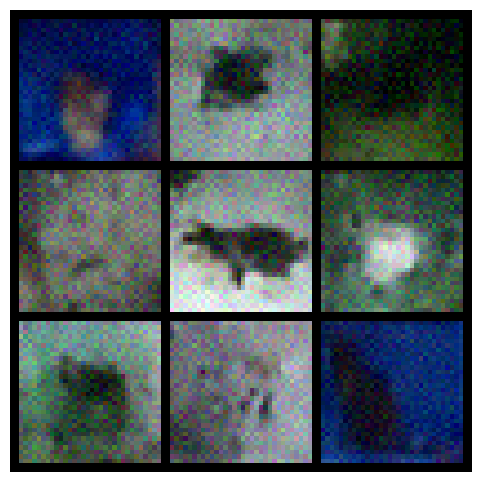

In [ ]:
from torchvision.utils import make_grid
import torch

## Load the pre-trained checkpoint from disk.
device = 'cuda'
ckpt = torch.load('/content/ckpt.pth')
model.load_state_dict(ckpt)

sample_batch_size = 9
sampler = pc.sample

## Generate samples using the specified sampler.
samples = sampler(sample_batch_size)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()